# Tutorial 1.2: Gradient descent-based two level optimization

- **Authors**: Xiaoyu Xie
- **Contact**: xiaoyuxie2020@u.northwestern.edu

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiaoyuxie-vico/PyDimension-Book/blob/main/examples/gradient_descent.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xiaoyuxie-vico/PyDimension-Book/HEAD)

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import matrix_rank
from numpy.linalg import inv
import pandas as pd
import pysindy as ps
import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy.optimize import minimize
random.seed(3)

## Parametric space analysis

Paraemter list:

$f(\eta P,V_s,r_0, C_p, \alpha, \rho, T_l-T_0)=e$

## Load dataset

In [2]:
data = np.loadtxt(
    open("../dataset/dataset_keyhole.csv","rb"),
    delimiter=',',
    skiprows=1,
    usecols = (2, 3, 4, 7, 5, 6, 10, 12)
)
X = data[:, :7]
Y = data[:, 7]

## Calculate dimension matrix

Dimension matrix (input):

\begin{equation}  
D_{in}=
\left[                
  \begin{array}{ccc}  
    2 & 1 & 1 & 2 &2&-3&0\\  
    -3 & -1 & 0 & -2 &-1&0&0\\  
    1& 0 & 0 & 0 &0&1&0\\
    0& 0 & 0 & -1 &0&0&1\\
  \end{array}
\right]              
\end{equation}

Dimension matrix (output):

\begin{equation}
D_{out}=
\left[                
  \begin{array}{ccc}  
    1 \\  
    0 \\  
    0 \\
    0 \\
  \end{array}
\right]              
\end{equation}

In [3]:
D_in = np.mat('2, 1, 1, 2, 2, -3, 0; -3, -1, 0, -2, -1, 0, 0; 1, 0, 0, 0, 0, 1, 0; 0, 0, 0, -1, 0, 0, 1')
D_out = np.mat('1; 0; 0; 0')
D_in_rank = matrix_rank(D_in)
print(D_in_rank)

4


## Calculate basis vectors

Calculate three basis vectors for equation:
$
D_{in}x=0
$


In [4]:
Din1 = D_in[:, 0:4]
Din2 = D_in[:, 4:8]

x2 = np.mat('-1; 0; 0')
x1 = -inv(Din1) * Din2 * x2
basis1_in = np.vstack((x1, x2))
print(f'basis1_in: \n{basis1_in}')

x2 = np.mat('0;-1;0')
x1 = -inv(Din1) * Din2 * x2
basis2_in = np.vstack((x1, x2))
print(f'basis2_in: \n{basis2_in}')

x2 = np.mat('0; 0; -1')
x1 = -inv(Din1) * Din2 * x2
basis3_in = np.vstack((x1, x2))
print(f'basis3_in: \n{basis3_in}')

basis1_in: 
[[ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 0.]]
basis2_in: 
[[ 1.]
 [-3.]
 [-2.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]]
basis3_in: 
[[ 0.]
 [ 2.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 0.]
 [-1.]]


## Helper functions

In [5]:
def calc_pi(a):
    '''
    Calculate pi
    Note that the best coef for keyhole is [0.5, 1, 1]
    '''
    coef_pi = 0.5 * basis1_in + a[0] * basis2_in + a[1] * basis3_in
    pi_mat = np.exp(np.log(X).dot(coef_pi))
    pi = np.squeeze(np.asarray(pi_mat))
    return pi

def calc_y(a, w):
    '''
    Calculate the prediction y using a polynomial function
    '''
    pi = calc_pi(a)
    y = w[0] + w[1] * pi + w[2] * pi**2 + w[3] * pi**3 + w[4] * pi**4 + w[5] * pi**5
    return y

def objective(a, w):
    '''
    Calculate objective(loss)
    '''
    return np.square(pi2 - calc_y(a, w)).mean()

def ploter(pi1, pi2, iteration):
    '''
    Visualization
    '''
    fig = plt.figure()
    plt.scatter(pi1, pi2)
    plt.xlabel(r'$\Pi_1$', fontsize=16)
    plt.ylabel(r'$\Pi_2$', fontsize=16)
    plt.title(f'Iteration: {iteration}', fontsize=24)
    plt.show()

## Best representation learning discovery

Initial a=[0.47592925 1.08845845]
Iteration: 0, coef: [0.47655508 1.08822897], Objective: 6.774411431102805, r2: -6.029830431357665


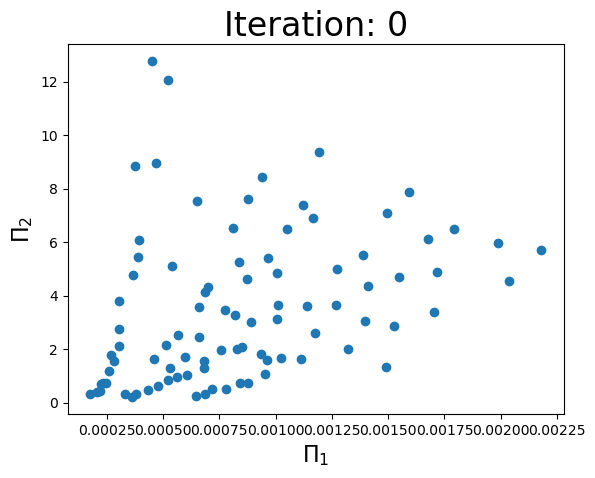

Iteration: 1000, coef: [0.83210715 0.91871379], Objective: 0.34713452499937103, r2: 0.9535269294147469


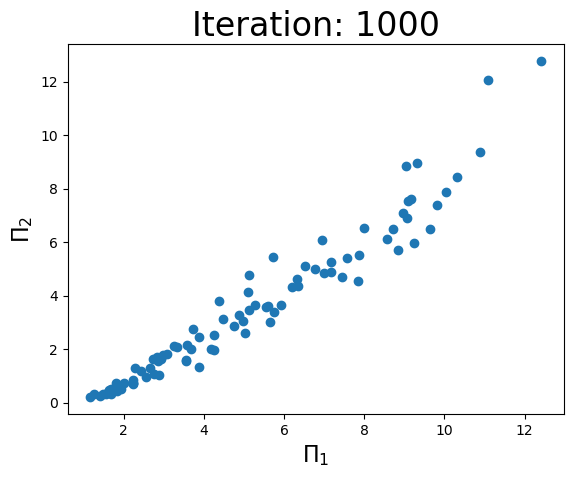

Iteration: 2000, coef: [0.88125833 0.8855296 ], Objective: 0.10920698118338781, r2: 0.9857184358093292


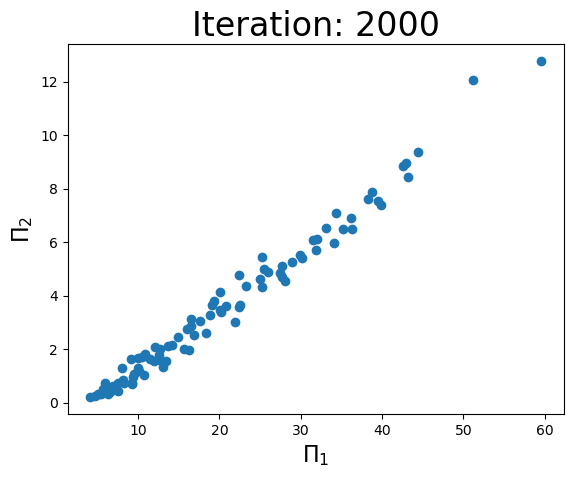

In [6]:
niter = 3000
ninital = 1
degree = 5  # polynomial order

a = np.zeros(2)
w = np.zeros(degree + 1)

global pi2
pi2 = Y / X[:,2]

poly = PolynomialFeatures(degree)

for j in range(ninital):
    a[0] = 2 * random.random()
    a[1] = 2 * random.random()
    print(f'Initial a={a}') 
    
    info = {}
    info['initial'] = a
    a_history = np.zeros((niter, 2))
    
    model = LinearRegression(fit_intercept=False)

    for i in range(niter):
        # level 1: update coefficient w for polynomials
        pi1 = calc_pi(a)
        
        pi1_poly = poly.fit_transform(pi1.reshape(-1, 1))
        
        model.fit(pi1_poly, pi2)
        
        coeffi = model.coef_
        w = coeffi
        
        y_recover = calc_y(a, w)       
        r2 = r2_score(y_recover, pi2)

        # level 2: update coefficient a for pi
        solution = minimize(objective, a, method='BFGS', tol=1e-3, args=w, options={'maxiter':1})
        a = solution.x
        y_recover = calc_y(a, w)
        r2 = r2_score(y_recover, pi2) 

        a_history[i,:] = a
        if i % int(niter // 3) == 0:
            # Note that the best coef in keyhole case is [0.5, 1, 1]
            # here we only optimize the last two coefficients
            print(f'Iteration: {i}, coef: {a}, Objective: {objective(a,w)}, r2: {r2}')
            ploter(pi1, pi2, i)